In [1]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Now we will display a fits file

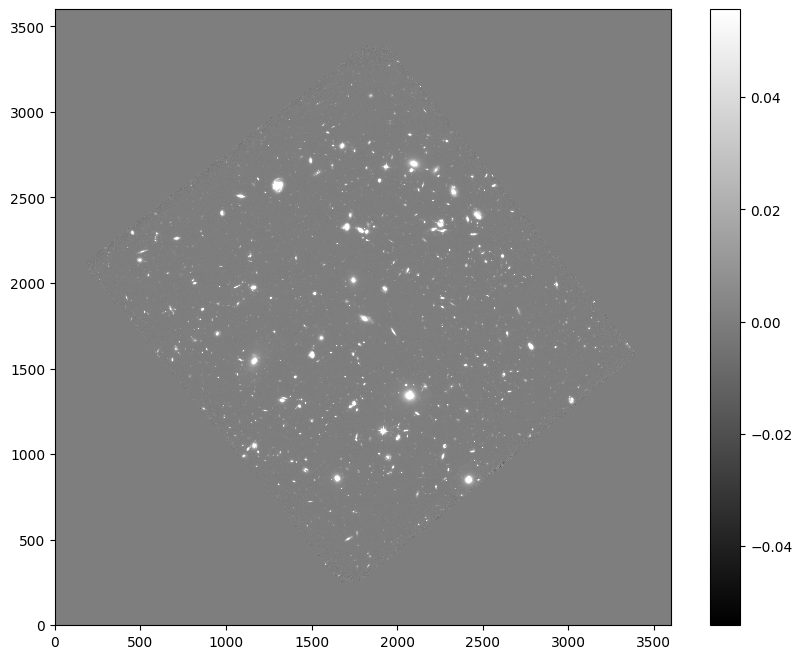

In [2]:
data = fits.getdata('f105w.fits')
data = data.byteswap(inplace=True).newbyteorder()

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

#save as png
plt.savefig("f105.png")

Measure spatially varying background of image

In [3]:
bkg = sep.Background(data)

Get a global mean and noise of background

In [4]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


Evaluate background as 2-d array

In [5]:
bkg_image = bkg.back()

Show background

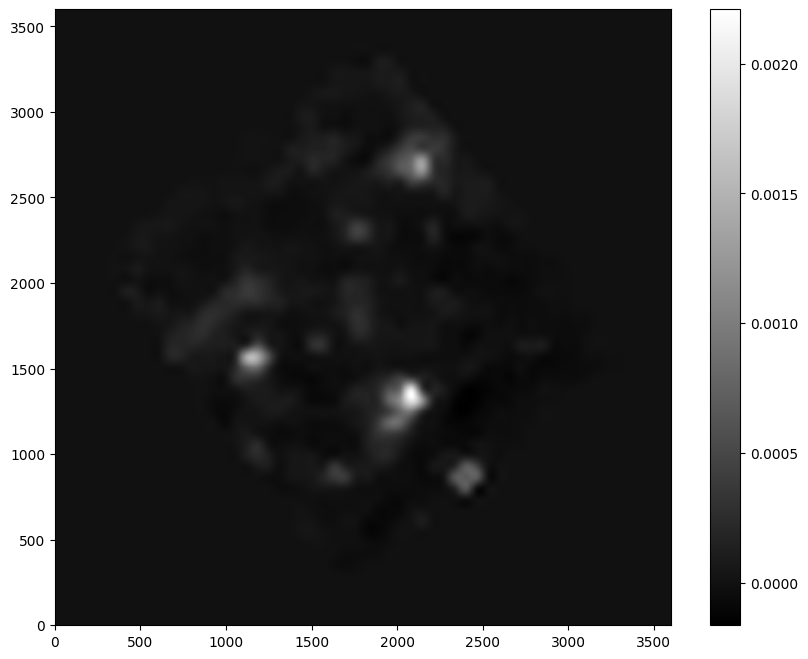

In [6]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save as png
plt.savefig("f105w2.png")

Now, we repeat the same process but for the background noise

In [7]:
bkg_rms = bkg.rms()

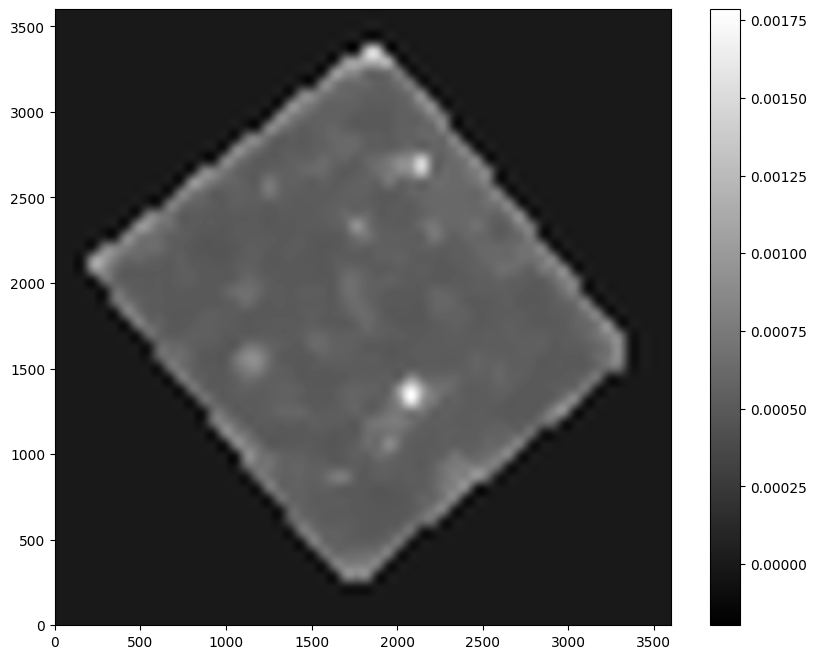

In [8]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save as png
plt.savefig("f105w3.png")

Now subtract the background from the image

In [9]:
data_sub = data - bkg

We will now detect objects on the background subtracted image. We will set the detection threshold to be 1.5 times the global background rms.

In [10]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
#how many objects detected?
len(objects)

8643

Over-plot the objects' coordinates with basic shape parameters onto the image

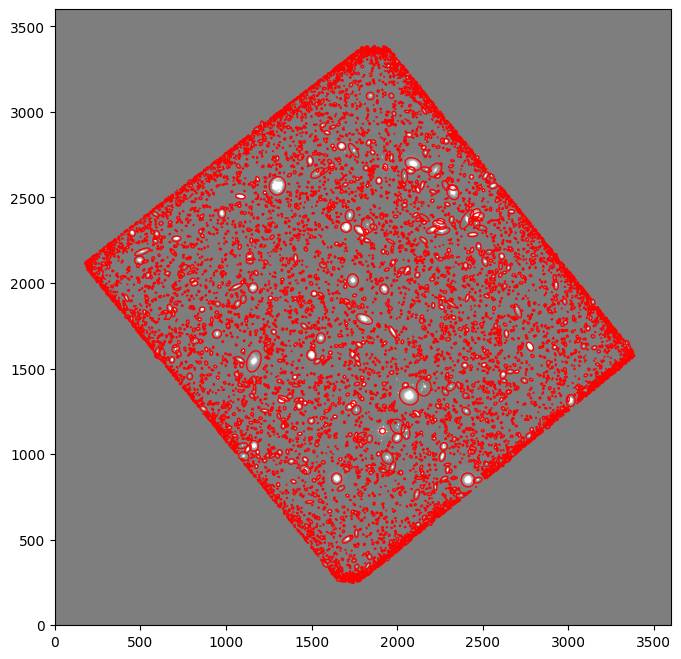

In [11]:
from matplotlib.patches import Ellipse

#plot background subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot ellipse around each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), 
                width=6*objects['a'][i], 
                height=6*objects['b'][i], 
                angle=objects['theta'][i]*180./np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
plt.savefig("f105w4.png")

look at available fields

In [12]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Simple aperture photometry with 3 pixel radius at each of the objects' locations

In [13]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                    3.0, err=bkg.globalrms, gain=1.0)

Show first 10 objects results

In [14]:
for i in range(10):
    print("object {:d}: flux +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux +/- 0.031282
object 1: flux +/- 0.031018
object 2: flux +/- -0.024388
object 3: flux +/- 0.001947
object 4: flux +/- 0.012457
object 5: flux +/- -0.011228
object 6: flux +/- 0.029368
object 7: flux +/- -0.009126
object 8: flux +/- 0.048023
object 9: flux +/- 0.027840


/tmp/ipykernel_212080/1488768299.py:1: RuntimeWarning: invalid value encountered in log10
  m_f105w = -2.5*np.log10(flux)


Text(0, 0.5, 'N')

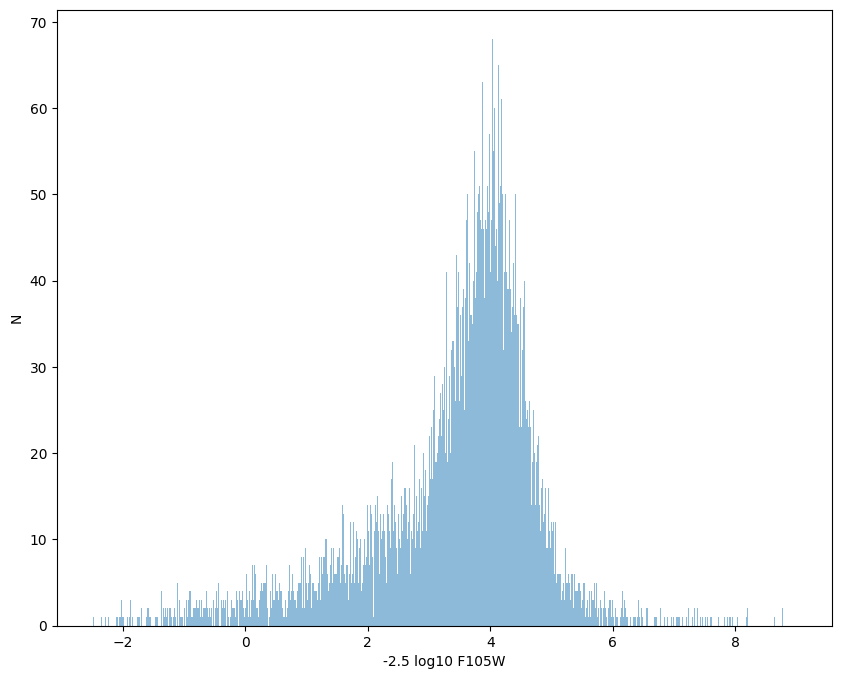

In [15]:
m_f105w = -2.5*np.log10(flux)
plt.hist(m_f105w, range=[-2.5,9],bins=1000,alpha=0.5)
plt.xlabel('-2.5 log10 F105W')
plt.ylabel('N')

In [16]:
print (np.mean(flux))
print (np.median(flux))
print (np.std(flux))

0.3617466258281149
0.030954822942148894
9.241925555851745


In [17]:
data_2 = fits.getdata('f125w.fits')
data_3 = fits.getdata('f160w.fits')

In [18]:
#Rescale data
def rescale_image(data):
    pdata_tmp = data.copy()
    m=np.nanmean(pdata_tmp)
    vplmin=m/2.
    vpmin=np.log10(vplmin)
    vpmax=np.log10(m*100)
    pdata_tmp[pdata_tmp<vplmin]=vplmin
    pdata_tmp=np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

[W 2024-12-10 10:46:27,969.969 matplotlib.image] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


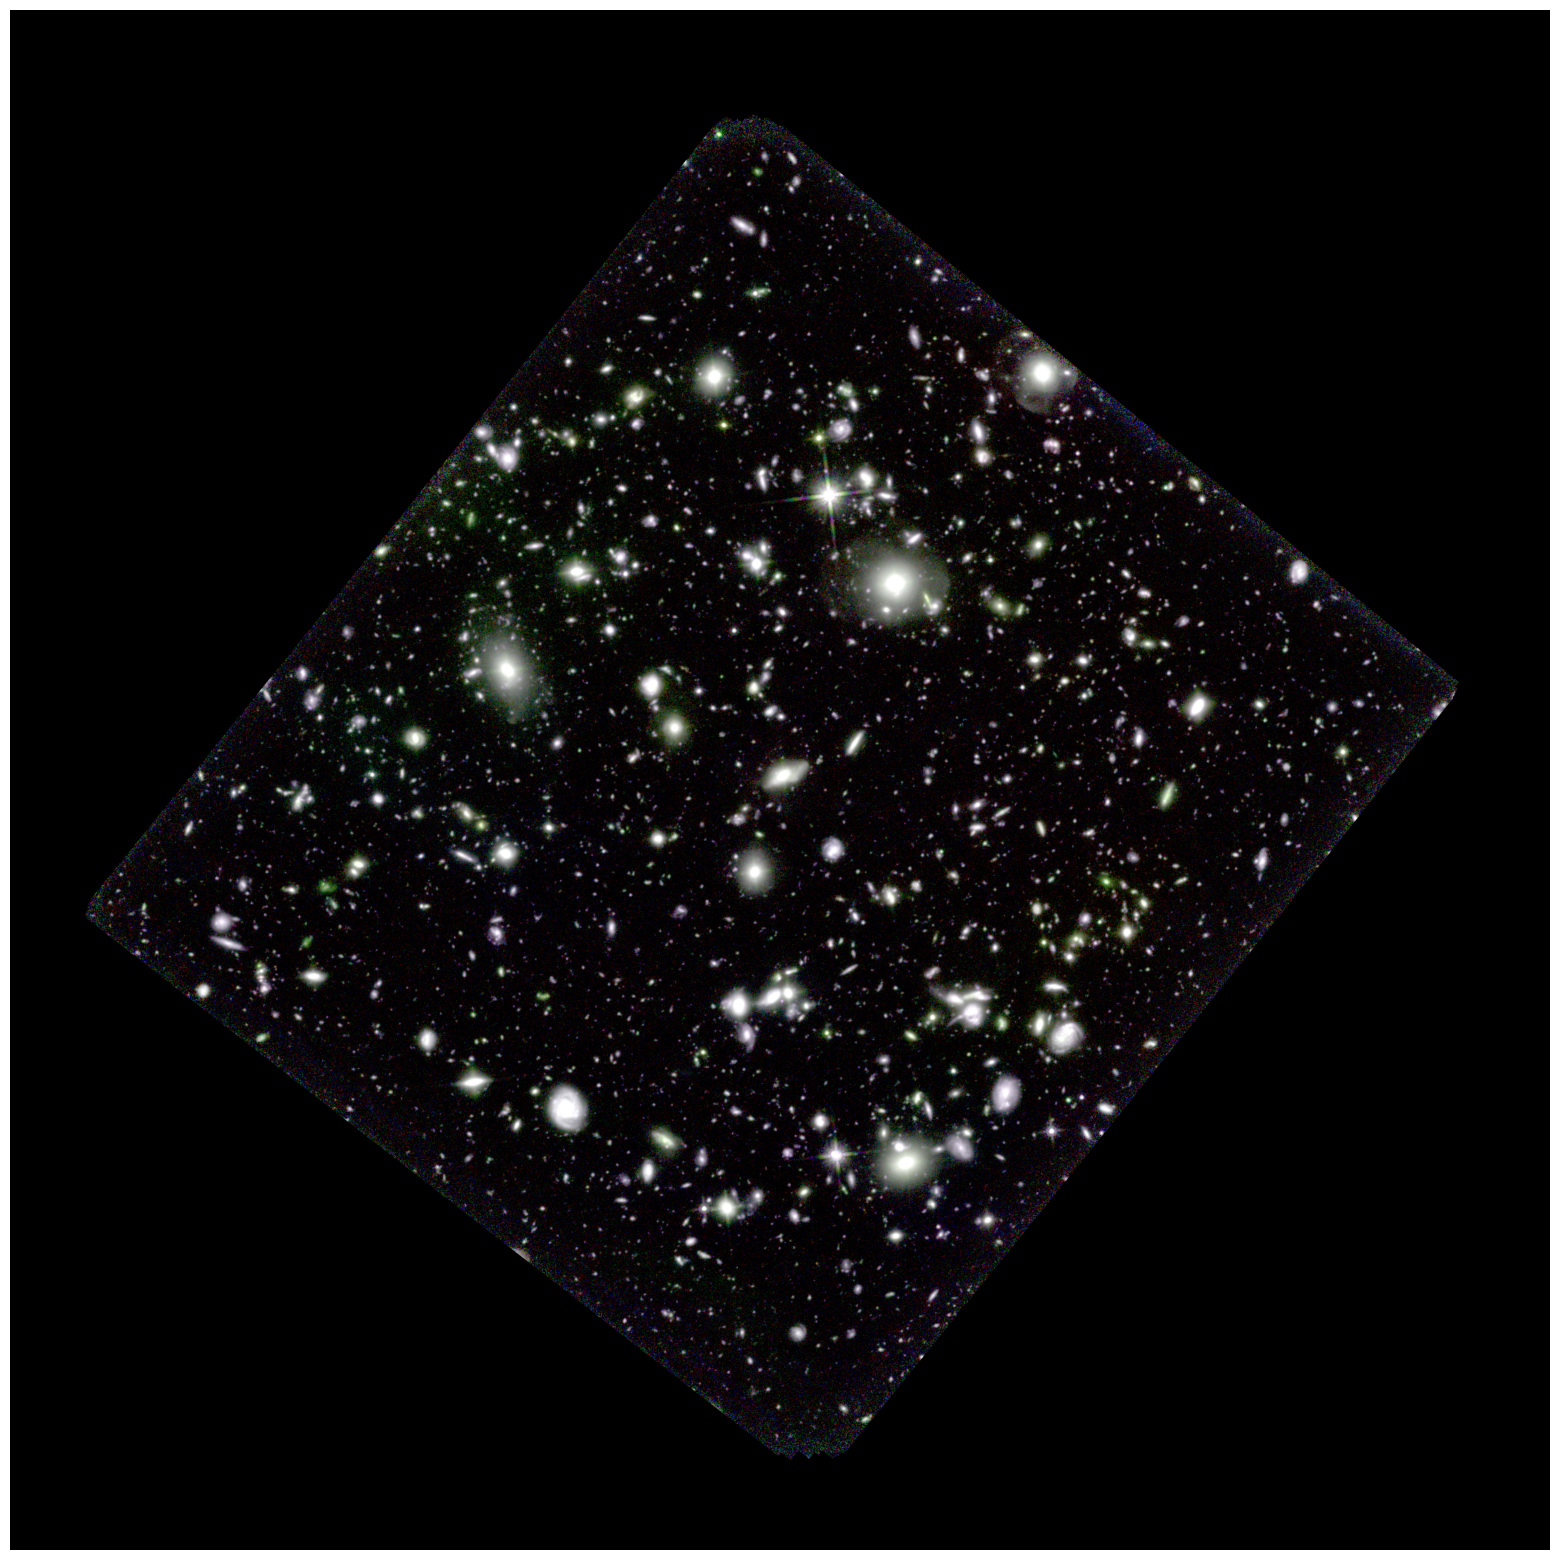

In [19]:
#Use rescaled image tos and make a 3-color image
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_res, dmin, dmax = rescale_image(data)

#limit data between min and max vals in rescaling
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max]=d2max
data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d3max]=d3max
data_res[data_res<dmin] = dmin
data_res[data_res>dmax]=dmax

rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1], 3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_res-dmin)/(dmax-dmin)

#plot RGB and save png
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('jwst_image.png',bbox_inches='tight',pad_inches=0,dpi=600)